# Exoplanet Classifer and Safronov Number
Emily Su, University of Toronto

In this notebook, we will look at the different exoplanets using the 2023 NASA Exoplanet Archive. We will first use the k-means clustering algorithm to classify them into different types. We will then calculate their Safronov numbers to measure their tendency to scatter bodies like planets out of their planetary system (McDonald & Veras, 2023; Safronov, 1972). 

We want to see the relationship between the type of exoplanet and its Safronov number and determine the likelihood of certain types of exoplanets scattering bodies in their planetary system.

In [429]:
# Libraries 
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

In [430]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [431]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Exoplanets/exoplanets.csv')
data.head()

,loc_rowid,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,...,ra,decstr,dec,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,rowupdate,pl_pubdate,releasedate
0,1,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,...,185.178779,+17d47m35.71s,17.793252,93.1846,4.72307,2.282,4.44038,2014-05-14,Jan-08,2014-05-14
1,2,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,...,185.178779,+17d47m35.71s,17.793252,93.1846,4.72307,2.282,4.44038,2014-07-23,Aug-11,2014-07-23
2,3,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,...,229.274595,+71d49m26.19s,71.823943,125.3210,5.01300,1.939,4.56216,2018-04-25,Oct-09,2014-05-14
3,4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,...,229.274595,+71d49m26.19s,71.823943,125.3210,5.01300,1.939,4.56216,2018-04-25,Aug-11,2014-07-23
4,5,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,...,229.274595,+71d49m26.19s,71.823943,125.3210,5.01300,1.939,4.56216,2018-09-04,Mar-17,2018-09-06


# Cleaning and Filtering Data

In [432]:
# Filter out columns
data_smaller = data[["hostname", "discoverymethod", "sy_pnum", "pl_rade", "pl_orbper", "pl_orbsmax", "pl_bmasse", "sy_dist", "pl_eqt", "st_mass", "releasedate"]]

# Filter out only exoplanets published by NASA Exoplanet Archive from 2023
data_filtered = data_smaller[pd.DatetimeIndex(data_smaller["releasedate"]).year == 2023]

# Removing duplicate
data_filtered.drop_duplicates(subset=["hostname"], inplace=True)
data_filtered.head()

<ipython-input-432-6a90cc24f527>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.drop_duplicates(subset=["hostname"], inplace=True)


,hostname,discoverymethod,sy_pnum,pl_rade,pl_orbper,pl_orbsmax,pl_bmasse,sy_dist,pl_eqt,st_mass,releasedate
143,AF Lep,Imaging,1,NaN,7520.000000,7.99000,1664.46737,26.8564,1400.0,1.20,2023-02-25
148,AU Mic,Transit,2,NaN,8.463210,NaN,NaN,9.7221,NaN,NaN,2023-05-03
284,CoRoT-3,Transit,1,11.624,4.256799,0.05783,6979.54680,768.7710,1695.0,1.40,2023-03-15
432,EPIC 220674823,Transit,2,1.725,0.571292,0.01326,8.21000,244.5900,2300.0,0.95,2023-04-17
451,EPIC 229004835,Transit,1,2.332,16.141132,0.12370,10.40000,121.9710,804.0,0.97,2023-05-03


# Classifying exoplanets 

We will classify exoplanets using their planetary mass (`pl_bmasse`) and their radius (`pl_rade`) into 3 clusters and each cluster would represent an exoplanet type. This will be done using k-means clustering.

In [433]:
# Obtain DataFrame with only host name, mass, radius, stellar mass, and orbit semi-major axis in AU 
mass_radius_semimajor = data_filtered[["hostname", "pl_bmasse", "pl_rade", "st_mass", "pl_orbsmax"]]

# DataFrame with just host name, mass, and radius
mass_radius = data_filtered[["hostname", "pl_bmasse", "pl_rade"]]

# Filter out rows with no value in one of the columns
mass_radius.dropna()

,hostname,pl_bmasse,pl_rade
284,CoRoT-3,6979.54680,11.624
432,EPIC 220674823,8.21000,1.725
451,EPIC 229004835,10.40000,2.332
464,G 9-40,11.70000,2.025
746,GJ 9827,5.14000,1.577
...,...,...,...
33320,TOI-778,878.00000,15.400
33329,TOI-836,4.53000,1.704
33496,V1298 Tau,203.41018,9.729
33513,VHS J125601.92-125723.9,5085.25451,13.675


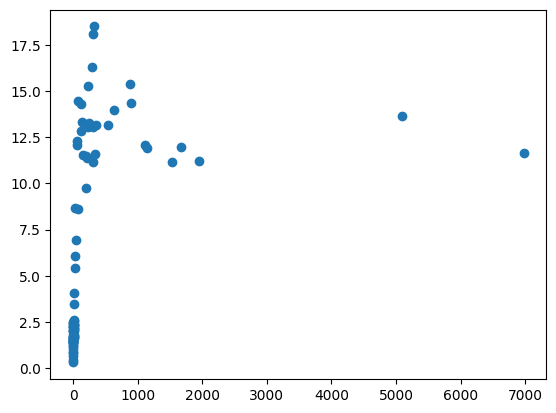

In [434]:
# Create temporary scatterplot (x-axis = mass and y-axis = radius)
plt.scatter(mass_radius["pl_bmasse"], mass_radius["pl_rade"])

In [435]:
# Creates 3 clusters
k_means = KMeans(n_clusters=3)

In [436]:
'''
This function takes in DataFrame for mass and radius and gets rid of rows 
containing "None" values.
and returns a DataFrame.
'''
def getCleanedDF(data):
 # Get rid of rows in each of all NA 
 data.dropna(inplace=True)

getCleanedDF(mass_radius)

new_mass_radius = mass_radius[["pl_bmasse", "pl_rade"]]
new_mass_radius.columns = ["Mass", "Radius"] # rename columns

clustering = k_means.fit_predict(new_mass_radius)
clustering

<ipython-input-436-bb59787e9c2e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0], dtype=int32)

In [437]:
# Add new column for cluster in the old and new mass_radius DataFrame
mass_radius["cluster"] = clustering
new_mass_radius["cluster"] = clustering

# Seperate each cluster into a DataFrame
cluster0 = new_mass_radius[new_mass_radius.cluster == 0]
cluster1 = new_mass_radius[new_mass_radius.cluster == 1]
cluster2 = new_mass_radius[new_mass_radius.cluster == 2]

<ipython-input-437-810916d59117>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_radius["cluster"] = clustering
<ipython-input-437-810916d59117>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_mass_radius["cluster"] = clustering


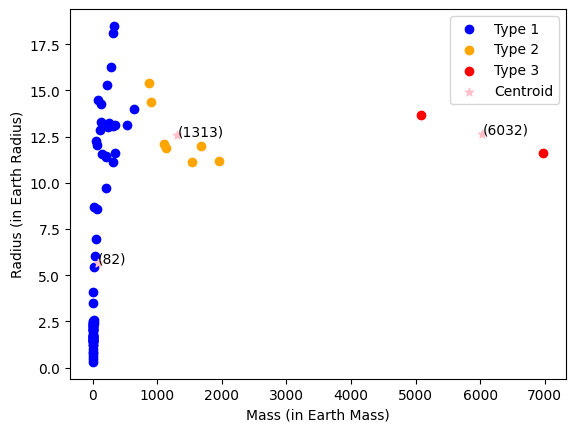

In [438]:
plt.scatter(cluster0.Mass, cluster0.Radius, color='blue', label = 'Type 1')
plt.scatter(cluster2.Mass, cluster2.Radius, color='orange', label = 'Type 2')
plt.scatter(cluster1.Mass, cluster1.Radius, color='red', label = 'Type 3')
plt.scatter(k_means.cluster_centers_[:,0],k_means.cluster_centers_[:,1],color='pink',marker='*',label='Centroid')
plt.xlabel('Mass (in Earth Mass)')
plt.ylabel('Radius (in Earth Radius)')
plt.legend()

# Label the aaverage mass of each type 
for i, j in zip(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,1]):
   plt.text(i, j, '({})'.format(round(i), j))

We will use each of the 3 centroids to approximate the exoplanet types. Looking at Type 1, its centroid is about $82 M_{Earth}$, which means it is $4.897 \text{ x } 10^{26}kg$. This makes it close to being Neptune-like ($1.024 \text{ x }10^{26} kg$). For Type 2, its centroid is about $1313 M_{Earth}$, which is $7.8415 \text{ x } 10^{27}kg$ and type 3, its centroid is around $6032 M_{Earth}$ or $3.6024 \text{ x } 10^{28}kg$. Both type 2 and type 3 can be both categorized as Gas Giants since both have a mass greater than Jupiter $1.898 \text{ x } 10^{27} kg$. As the centroid for type 2 is closer to Jupiter's mass, it can be categorized in a sub-category called "Jupiter-like". 

Text(0.5, 1.0, 'Emily Su, University of Toronto')

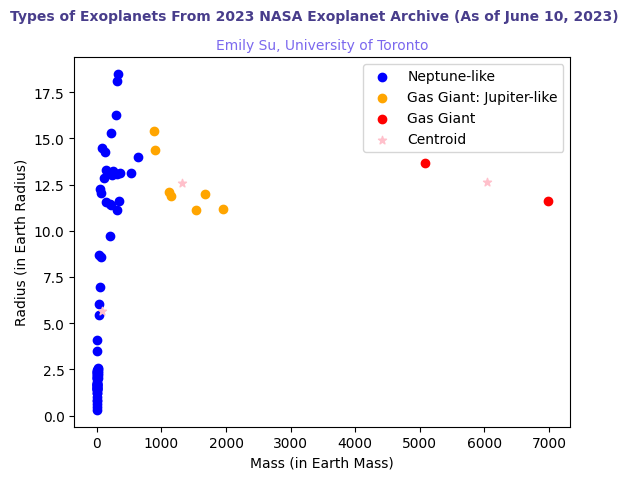

In [439]:
cluster0_splot = plt.scatter(cluster0.Mass, cluster0.Radius, color='blue', label = 'Neptune-like')
cluster2_splot = plt.scatter(cluster2.Mass, cluster2.Radius, color='orange', label = 'Gas Giant: Jupiter-like')
cluster1_splot = plt.scatter(cluster1.Mass, cluster1.Radius, color='red', label = 'Gas Giant')
splot = plt.scatter(k_means.cluster_centers_[:,0],k_means.cluster_centers_[:,1],color='pink',marker='*',label='Centroid')
plt.xlabel('Mass (in Earth Mass)')
plt.ylabel('Radius (in Earth Radius)')
plt.legend()

plt.suptitle("Types of Exoplanets From 2023 NASA Exoplanet Archive (As of June 10, 2023)",
          fontsize=10,
          fontweight="bold",
          color="darkslateblue")
plt.title("Emily Su, University of Toronto",
          fontsize=10,
          color="mediumslateblue")

# Calculating Average Safronov Number of Each Type of Exoplanets 

We will calculate the Safronov number of each exoplanet using the following formula (Safronov, 1972; McDonald & Veras, 2023): 
$$\theta = \frac{a}{R}\frac{M_p}{M_{s}}$$

**Notations**:\
a = the orbit semi-major axis (m)\
R = radius of the planet (m)\
$M_p$ = mass of the planet (kg)\
$M_s$ = mass of the star (kg)


In [440]:
# Make a deep copy 
mass_radius_semimajor.copy().head()

,hostname,pl_bmasse,pl_rade,st_mass,pl_orbsmax
143,AF Lep,1664.46737,NaN,1.20,7.99000
148,AU Mic,NaN,NaN,NaN,NaN
284,CoRoT-3,6979.54680,11.624,1.40,0.05783
432,EPIC 220674823,8.21000,1.725,0.95,0.01326
451,EPIC 229004835,10.40000,2.332,0.97,0.12370


In [441]:
# Convert units

# orbit semi-major axis - from AU to m 

# radius - from earth radius to m

# mass of planet - from earth mass to kg 

# mass of star - from solar mass to kg 

# References

Catriona, H. M., & Veras, D. (2023). Binary asteroid scattering around white dwarfs. *Monthly Notices of the Royal Astronomical Society*, *520*(3), 4009–4022, https://doi.org/10.1093/mnras/stad382

Safronov, V. S. (1972). *Evolution of the protoplanetary cloud and formation of the earth and the
planets.* Keter Publishing House.
  